# Processing POI data from Liverpool

Author: [Huanfa Chen](https://github.com/huanfachen)

In [1]:
import datetime
print("Last update:", datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

Last update: 30/08/2022 16:49:50


Some notes:
1. If a cell starts with `%%script false --no-raise-error`, this cell is skipped and not run. If you understand this cell and want to run it, you can uncomment this line and run the cell.

## Import packages

In [43]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import utilities
from compute_pairwise_distance import compute_pairwise_distance

## Read in POI data

In [3]:
# read the POI data
df_poi = pd.read_csv("Liverpool_hub_four_POI/poi_4565130/poi-extract-2022_03.csv", sep="|")

In [4]:
df_poi.columns

Index(['ref_no', 'name', 'pointx_class', 'feature_easting', 'feature_northing',
       'pos_accuracy', 'uprn', 'topo_toid', 'topo_toid_version', 'usrn',
       'usrn_mi', 'distance', 'address_detail', 'street_name', 'locality',
       'geographic_county', 'postcode', 'admin_boundary', 'telephone_number',
       'url', 'brand', 'qualifier_type', 'qualifier_data', 'provenance',
       'supply_date'],
      dtype='object')

In [5]:
df_poi_by_class = df_poi.pointx_class.value_counts().to_frame().reset_index().rename(columns={"index": "class", "pointx_class": "number"})
df_poi_by_class['class_4d'] = df_poi_by_class['class'].apply(lambda x: str(x)[-4:])

## Read in POI classifications and join the POI data with classifications

In [6]:
df_poi_class_table = pd.read_csv("Liverpool_hub_four_POI/poi_4565130/docs/POI_CLASSIFICATIONS.txt", sep = "|", dtype=object)
# .["Class Number","Classification Description"]
df_poi_class_table.columns

Index(['ID', 'Class Number', 'Classification Description',
       'Category Number Foreign Key'],
      dtype='object')

In [7]:
df_poi_by_class = pd.merge(how='left',
         left= df_poi_by_class, 
         right=df_poi_class_table, 
         left_on='class_4d', right_on='Class Number')

In [8]:
df_poi_by_class.head(50)

,class,number,class_4d,ID,Class Number,Classification Description,Category Number Foreign Key
0,10590732,536,0732,619,0732,BUS STOPS,59
1,6340433,415,0433,350,0433,ELECTRICAL FEATURES,34
2,1020034,383,0034,14,0034,"PUBS, BARS AND INNS",02
3,2100156,315,0156,118,0156,HAIR AND BEAUTY SERVICES,10
4,1020018,247,0018,10,0018,FAST FOOD AND TAKEAWAY OUTLETS,02
5,1020043,234,0043,15,0043,RESTAURANTS,02
6,3200269,231,0269,217,0269,UNSPECIFIED AND OTHER ATTRACTIONS,20
7,9470699,223,0699,536,0699,CONVENIENCE STORES AND INDEPENDENT SUPERMARKETS,47
8,1020013,215,0013,9,0013,"CAFES, SNACK BARS AND TEA ROOMS",02
9,2090141,166,0141,98,0141,CASH MACHINES,09


In [9]:
df_poi.shape
# 7693 POIs in total

(7693, 25)

## Selecting several types of POI as candidate sites for the case study

First, types of POIs used in the location-allocation analysis in Feng et al. 2021:

```
The U.S. Geological Survey maintains the National Structures Dataset that contains data on Fire/Police Stations, Hospital/Medical Centers, Ambulance Services, etc. We used this data in defining possible drone sites. Fig. 4 shows the 520 potential stations in the study area, among which the stations are selected to equip drones.

40 stations are selected to equip the drones.
```

We select the following types of POIs:
- 343|"0422"|"POLICE STATIONS"|"33"
- 337|"0414"|"FIRE BRIGADE STATIONS"|"33"
- 301|"0106"|"MEDICAL EQUIPMENT RENTAL AND LEASING"|"29"
- 302|"0356"|"AMBULANCE AND MEDICAL TRANSPORTATION SERVICES"|"29"
- 613|"0731"|"BUS AND COACH STATIONS, DEPOTS AND COMPANIES"|"57"
- 614|"0738"|"RAILWAY STATIONS, JUNCTIONS AND HALTS"|"57"
- 615|"0756"|"TRAM, METRO AND LIGHT RAILWAY STATIONS AND STOPS"|"57"
- 616|"0758"|"TAXI RANKS"|"57"
- 617|"0761"|"UNDERGROUND NETWORK STATIONS"|"57"
- 618|"0794"|"LONDON UNDERGROUND ENTRANCES"|"57"
- 247|"0293"|"GYMNASIUMS, SPORTS HALLS AND LEISURE CENTRES"|"24"
- 362|"0456"|"HALLS AND COMMUNITY CENTRES"|"34"

In [10]:
def check_number_POI(list_poi_class):
    print(df_poi[df_poi["pointx_class"].astype(str).str.contains('|'.join(list_poi_class))].shape[0])

In [11]:
# how many sites are in these types? Only 8
list_poi_class = ["0422","0414","0106","0356","0293", "0456"]

check_number_POI(list_poi_class)

93


This can be the case study: **SELECT 10 out of 93 candidate sites in the p-median problem (PMP).**

In [12]:
# visualise the map of these POIs
list_poi_class = ["0422","0414","0106","0356","0293", "0456"]
df_poi_subset = df_poi[df_poi["pointx_class"].astype(str).str.contains('|'.join(list_poi_class))]

In [13]:
print(df_poi_subset.columns)
print(df_poi_subset.shape[0])

Index(['ref_no', 'name', 'pointx_class', 'feature_easting', 'feature_northing',
       'pos_accuracy', 'uprn', 'topo_toid', 'topo_toid_version', 'usrn',
       'usrn_mi', 'distance', 'address_detail', 'street_name', 'locality',
       'geographic_county', 'postcode', 'admin_boundary', 'telephone_number',
       'url', 'brand', 'qualifier_type', 'qualifier_data', 'provenance',
       'supply_date'],
      dtype='object')
93


In [14]:
%%script false --no-raise-error
gdf_poi = gpd.GeoDataFrame(
    df_poi_subset, geometry=gpd.points_from_xy(df_poi_subset.feature_easting, df_poi_subset.feature_northing))
gdf_poi = gdf_poi.set_crs('epsg:27700')

%%script false --no-raise-error
# add a column of 'site_id' to gdf_poi. get a dataframe of lat, long, easting, northing
gdf_poi["site_id"] = np.arange(len(gdf_poi))
gdf_poi_wgs = gdf_poi.to_crs("epsg:4326")
gdf_poi["long"],gdf_poi["lat"] = gdf_poi_wgs.geometry.x, gdf_poi_wgs.geometry.y
# write gdf_poi to geojson
gdf_poi.to_file("Sites_Liverpool_hub_four.geojson", driver = 'GeoJSON')

In [15]:
gdf_poi = gpd.read_file("Sites_Liverpool_hub_four.geojson")
print(gdf_poi.columns)

Index(['ref_no', 'name', 'pointx_class', 'feature_easting', 'feature_northing',
       'pos_accuracy', 'uprn', 'topo_toid', 'topo_toid_version', 'usrn',
       'usrn_mi', 'distance', 'address_detail', 'street_name', 'locality',
       'geographic_county', 'postcode', 'admin_boundary', 'telephone_number',
       'url', 'brand', 'qualifier_type', 'qualifier_data', 'provenance',
       'supply_date', 'site_id', 'long', 'lat', 'geometry'],
      dtype='object')


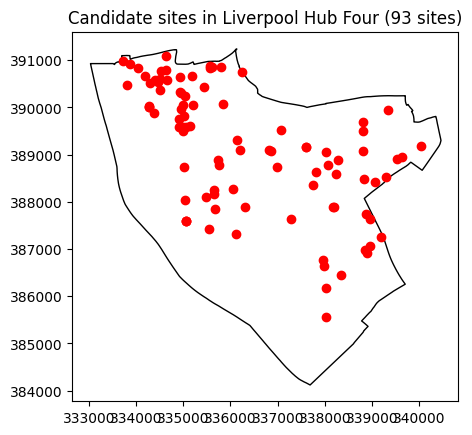

In [16]:
# plot gdf_poi
# read the boundary of Liverpool Hub Four
gdf_liverpool_hub_four = gpd.read_file("Liverpool_hub_four_neighbourhood.geojson")
ax = gdf_liverpool_hub_four.plot(color='white', edgecolor='black')
gdf_poi.plot(ax=ax, color='red')
plt.title("Candidate sites in Liverpool Hub Four (93 sites)")
plt.show()

## Calculate distance matrix

In [17]:
# read in street segments
gdf_street_segments = gpd.read_file("nkde_crime_Liverpool_hub_four.geojson")

In [18]:
gdf_street_segments.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [19]:
gdf_street_segments.columns

Index(['lineID', 'osm_id', 'name', 'X3', 'abandoned', 'abandoned.', 'abutters',
       'access', 'addr.city', 'addr.house',
       ...
       'length', 'density', 'demand_id', 'feature_ea', 'feature_no', 'long',
       'lat', 'feature_easting', 'feature_northing', 'geometry'],
      dtype='object', length=203)

In [20]:
%%script false --no-raise-error
# add demand_id
gdf_street_segments["demand_id"] = np.arange(len(gdf_street_segments))
# add feature_easting and feature_northing from geometry data
gdf_street_segments["feature_easting"], gdf_street_segments["feature_northing"] = gdf_street_segments.geometry.x, gdf_street_segments.geometry.y
# transform to WGS84 
gdf_street_segments_wgs = gdf_street_segments.to_crs("epsg:4326")
gdf_street_segments["long"],gdf_street_segments["lat"] = gdf_street_segments_wgs.geometry.x, gdf_street_segments_wgs.geometry.y 

In [21]:
%%script false --no-raise-error
gdf_street_segments.to_file("nkde_crime_Liverpool_hub_four.geojson", driver = "GeoJSON")

In [22]:
df_site = gdf_poi[["site_id", "long", "lat", "feature_easting", "feature_northing"]].rename(columns={"long":"site_long", "lat":"site_lat", "feature_easting":"site_easting", "feature_northing":"site_northing" })

In [23]:
df_demand = gdf_street_segments[["demand_id", "long", "lat", "feature_easting", "feature_northing"]].rename(columns={"long":"demand_long", "lat":"demand_lat", "feature_easting":"demand_easting", "feature_northing":"demand_northing" })

In [24]:
# cartesian product in pandas
df_distance = df_site.merge(df_demand, how='cross')
df_distance.columns

Index(['site_id', 'site_long', 'site_lat', 'site_easting', 'site_northing',
       'demand_id', 'demand_long', 'demand_lat', 'demand_easting',
       'demand_northing'],
      dtype='object')

In [25]:
print(df_site.shape[0])
print(df_demand.shape[0])
print(df_distance.shape[0] - df_site.shape[0]*df_demand.shape[0])

93
1710
0


### Euclidean distance

In [26]:
df_distance.dtypes

site_id              int64
site_long          float64
site_lat           float64
site_easting       float64
site_northing      float64
demand_id            int64
demand_long        float64
demand_lat         float64
demand_easting     float64
demand_northing    float64
dtype: object

In [27]:
df_distance['Euclidean'] = np.sqrt(np.square(df_distance.demand_easting - df_distance.site_easting) + 
                                   np.square(df_distance.demand_northing - df_distance.site_northing))

In [28]:
# test pivot_table
df_test = df_distance.iloc[:5,]

In [29]:
print(df_test)

   site_id  site_long   site_lat  site_easting  site_northing  demand_id  \
0        0  -2.962924  53.387355      336054.0       388267.0          0   
1        0  -2.962924  53.387355      336054.0       388267.0          1   
2        0  -2.962924  53.387355      336054.0       388267.0          2   
3        0  -2.962924  53.387355      336054.0       388267.0          3   
4        0  -2.962924  53.387355      336054.0       388267.0          4   

   demand_long  demand_lat  demand_easting  demand_northing    Euclidean  
0    -2.913968   53.394686   339320.415381    389039.829352  3356.595693  
1    -2.911148   53.394061   339507.021123    388967.900086  3523.438066  
2    -2.908332   53.393432   339693.431628    388895.457235  3693.294068  
3    -2.905632   53.392660   339871.898002    388807.293089  3855.938508  
4    -2.903148   53.391646   340035.599615    388692.461849  4004.266884  


In [30]:
df_test_pivot = pd.pivot_table(df_test, values='Euclidean', index=['site_id'],
                    columns=['demand_id'], aggfunc=np.sum)

In [31]:
df_test_pivot.columns

Int64Index([0, 1, 2, 3, 4], dtype='int64', name='demand_id')

In [32]:
df_distance.columns

Index(['site_id', 'site_long', 'site_lat', 'site_easting', 'site_northing',
       'demand_id', 'demand_long', 'demand_lat', 'demand_easting',
       'demand_northing', 'Euclidean'],
      dtype='object')

In [33]:
# The distance matrix required by spopt is a M*N matrix, with M rows and N columns corresponding to demands and sites
df_distance_pivot_Euclidean = pd.pivot_table(df_distance, values='Euclidean', index=['demand_id'],
                    columns=['site_id'], aggfunc=np.sum)

In [35]:
# save as Euclidean_distance_site_demand.csv
file_distance_Euclidean = 'distance_matrix_demand_site_Euclidean.csv'
df_distance_pivot_Euclidean.to_csv(file_distance_Euclidean)

In [36]:
# check this dataset - is it correct?
from scipy import stats
stats.describe(df_distance_pivot_Euclidean.to_numpy().flatten())

DescribeResult(nobs=159030, minmax=(6.857566107243913, 8363.349912077383), mean=2629.3906459657437, variance=2342088.4896041877, skewness=0.46472054949008373, kurtosis=-0.6030650967716884)

In [37]:
# read in this csv and transform it into an ndarray. 
array_distance_Eudlidean = utilities.read_distance_matrix_as_np_array(file_distance_Euclidean)
# array_distance_Eudlidean is a numpy array, with rows and columns corresponding to demands and sites, respectively

In [38]:
assert(array_distance_Eudlidean.shape == (1710, 93))

### Network distance

In [39]:
# the largest Euclidean distance
array_distance_Eudlidean.max().max()

8363.349912077383

In [40]:
print(df_site.columns)
print(df_demand.columns)

Index(['site_id', 'site_long', 'site_lat', 'site_easting', 'site_northing'], dtype='object')
Index(['demand_id', 'demand_long', 'demand_lat', 'demand_easting',
       'demand_northing'],
      dtype='object')


In [41]:
df_demand[['demand_id', 'demand_long', 'demand_lat']].__class__

pandas.core.frame.DataFrame

In [44]:
# using OSRM
cutoff_distance = 100000
df_distance_network = compute_pairwise_distance(df_demand[['demand_id', 'demand_long', 'demand_lat']], df_site[['site_id', 'site_long', 'site_lat']], cutoff_distance, False, True)


Progress bar:: 100%|██████████| 159030/159030 [17:10<00:00, 154.39it/s]


In [45]:
print(df_distance_network.columns)
print(df_distance.columns)

Index(['origin_id', 'dest_id', 'distance'], dtype='object')
Index(['site_id', 'site_long', 'site_lat', 'site_easting', 'site_northing',
       'demand_id', 'demand_long', 'demand_lat', 'demand_easting',
       'demand_northing', 'Euclidean'],
      dtype='object')


In [46]:
# rename
df_distance_network = df_distance_network.rename(columns={'distance':'network', 'origin_id':'demand_id', 'dest_id':'site_id'})
# check if network distance is always larger than Euclidean distance
df_distance = df_distance.merge(df_distance_network, how = 'left')

In [49]:
df_diff_Euclidean_network = df_distance[['Euclidean', 'network']].diff(axis=1)
df_diff_Euclidean_network[df_diff_Euclidean_network < 0.0].count()

Euclidean         0
network      158817
dtype: int64

In [50]:
# The distance matrix required by spopt is a M*N matrix, with M rows and N columns corresponding to demands and sites
df_distance_pivot_network = pd.pivot_table(df_distance, values='network', index=['demand_id'],
                    columns=['site_id'], aggfunc=np.max)

In [51]:
print(df_distance_pivot_network.index)
print(df_distance_pivot_network.columns)

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709],
           dtype='int64', name='demand_id', length=1710)
Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
            85, 86, 87, 88, 89, 90, 91, 92],
           dtype='int64', name='site_id')


In [52]:
# save as distance_matrix_demand_site_network.csv
file_distance_network = 'distance_matrix_demand_site_network.csv'
df_distance_pivot_network.to_csv(file_distance_network)

In [53]:
# check this dataset - is it correct?
from scipy import stats
stats.describe(df_distance_pivot_network.to_numpy().flatten())

DescribeResult(nobs=159030, minmax=(0.4, 16771.3), mean=3644.056078098472, variance=3959168.731285362, skewness=0.9212967699052389, kurtosis=1.7169753266711005)

In [54]:
array_distance_Eudlidean = utilities.read_distance_matrix_as_np_array(file_distance_network)
assert(array_distance_Eudlidean.shape == (1710, 93))

In [59]:
# install PythonRobotics library
# !mkdir tmp_folder
# !git clone https://github.com/AtsushiSakai/PythonRobotics.git

Cloning into 'PythonRobotics'...
remote: Enumerating objects: 10682, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 10682 (delta 79), reused 188 (delta 74), pack-reused 10481
Receiving objects: 100% (10682/10682), 290.01 MiB | 13.25 MiB/s, done.
Resolving deltas: 100% (6055/6055), done.
Checking connectivity... done.


In [78]:
# !pip3 --no-cache-dir install raster2xyz

  Created wheel for raster2xyz: filename=raster2xyz-0.1.3-py3-none-any.whl size=5964 sha256=5abe0ac6650785232dc116567a9d3737c53195536157e9974875115a47b00fa2
  Stored in directory: /tmp/pip-ephem-wheel-cache-bbm7endx/wheels/07/4b/5d/fc666340cb735a7a79d149be0acd64dff8edec947dba612d70
Successfully built raster2xyz


### Download the DTM data

In [28]:
def raster_to_csv(input_raster, out_csv):
    # import raster2xyz
    from raster2xyz.raster2xyz import Raster2xyz
    rtxyz = Raster2xyz()
    rtxyz.translate(input_raster, out_csv)
    df_raster = pd.read_csv(out_csv)
    return(df_raster) 

In [29]:
%%script false --no-raise-error
%%bash
# extract the tif files from the zip files
cd DTM
for file in *.zip
do
tiff_file_name=$(echo $file | grep -oE 'SJ[[:alnum:]]+')_DTM_2m.tif
unzip -p $file $tiff_file_name > $tiff_file_name
done
# !unzip './DTM/LIDAR-DTM-2m-2020-SJ38ne.zip'

In [30]:
%%script false --no-raise-error
# merge the tiff files into DTM/DTM_merge.tif
!ls DTM/*.tif
!python gdal_merge.py -o DTM/DTM_merge.tif DTM/*.tif

In [31]:
# the original resolution is 2m, x_size = 7500, y_size = 7500
# resample to 20m?
from osgeo import gdal

# open reference file and get resolution
input_tiff = "DTM/DTM_merge.tif"
input_tiff = gdal.Open(input_tiff, 0)  # this opens the file in only reading mode
resolution = input_tiff.GetGeoTransform()
# see https://gdal.org/user/raster_data_model.html
# https://gdal.org/python/osgeo.gdal-module.html#WarpOptions
print("pixel width: {}".format(resolution[1]))
print("pixel height: {}".format(-resolution[5]))
print(resolution)
# the X and Y resolution are 2m and 2m

pixel width: 2.0
pixel height: 2.0
(330000.0, 2.0, 0.0, 395000.0, 0.0, -2.0)


Downsampling the pixels by 10 times does not work. Instead, a three-step approach is used that downsamples the pixels by 2.5, 2, and 2 times, respectively.

In [44]:
## The code does not work
#  times = 10
# x_res_new = resolution[1] * times # new resolution is 20m and 20m
# y_res_new = -resolution[5] * times  # make sure this value is positive

# # specify input and output filenames
# inputFile = "DTM/DTM_merge.tif"
# outputFile = "DTM/DTM_merge_{}m_{}m.tif".format(int(x_res_new), int(y_res_new))
# # outputFile = "DTM/DTM_merge_6m_6m.tif"

# # call gdal Warp
# kwargs = {"format": "GTiff", "xRes": x_res_new, "yRes": y_res_new, "resampleAlg": 'max', 'srcNodata': 'np.nan'}
# ds = gdal.Warp(outputFile, inputFile, **kwargs)

In [32]:
%%script false --no-raise-error
# A three-step approach: downsample by 2.5, 2, and 2 times
list_times = [2.5,2,2]
list_x_res = [resolution[1] * i for i in list_times]
list_y_res = [-resolution[5] * i for i in list_times] 
inputFile = "DTM/DTM_merge.tif"
for times, x_res, y_res in zip(list_times, list_x_res, list_y_res):
    outputFile = "DTM/DTM_merge_{}m_{}m.tif".format(int(x_res), int(y_res))
    kwargs = {"format": "GTiff", "xRes": x_res, "yRes": y_res, "resampleAlg": 'max'}
    ds = gdal.Warp(outputFile, inputFile, **kwargs)
    inputFile = outputFile

In [33]:
# check the new tiff and resample
outputFile = "DTM/DTM_merge_20m_20m.tif"
from osgeo import gdal
raster_DTM = gdal.Open("DTM/DTM_merge_20m_20m.tif")
raster_DTM = gdal.Open(outputFile)
# raster_DTM = gdal.Open("DTM/DTM_merge.tif")
# number of raster bands
# print(raster_DTM.RasterCount)
print("Width: {}, Height: {}".format(raster_DTM.RasterXSize,raster_DTM.RasterYSize))
# print("crs: {}".format(raster_DTM.GetProjection()))
print("band count:", raster_DTM.RasterCount)


Width: 750, Height: 750
band count: 1


In [34]:
# check band statistics
# Read the raster band as separate variable
band = raster_DTM.GetRasterBand(1)
print(type(band))
print(band.ComputeStatistics(0))
print ("[ NO DATA VALUE ] = ", band.GetNoDataValue())
print(band.GetMinimum())
print(band.GetMaximum())
print(band.GetMetadata())

<class 'osgeo.gdal.Band'>
[-7.348299026489258, 92.55000305175781, 26.110641168043763, 18.809611938689525]
[ NO DATA VALUE ] =  0.0
-7.3482990264893
92.550003051758
{'STATISTICS_MAXIMUM': '92.550003051758', 'STATISTICS_MEAN': '26.110641168044', 'STATISTICS_MINIMUM': '-7.3482990264893', 'STATISTICS_STDDEV': '18.80961193869'}


In [35]:
# transform the merged tiff into csv file
# df_dtm = raster_to_csv('DTM/DTM_merge.tif', 'DTM/DTM_merge.csv')
df_dtm = raster_to_csv('DTM/DTM_merge_20m_20m.tif', 'DTM/DTM_merge_20m_20m.csv')

[2022-06-21 11:48:57 - INFO] - Getting geotransform and data...
[2022-06-21 11:48:57 - INFO] - Getting XYZ data...
[2022-06-21 11:48:57 - INFO] - Getting geotransformed coordinates...
[2022-06-21 11:48:57 - INFO] - Building XYZ data...
[2022-06-21 11:48:58 - INFO] - New XYZ (csv file) created...


In [36]:
# check df_dtm
print("Shape of df_dtm:", df_dtm.shape)
print("summary of height data")
print(df_dtm.z.describe())

Shape of df_dtm: (562500, 3)
summary of height data
count    562500.000000
mean         26.110641
std          18.809629
min          -7.348299
25%           8.982500
50%          27.008874
75%          39.312812
max          92.550000
Name: z, dtype: float64


### Test the A* distance

The D* distance is not suitable for this project as it is very inefficient for a map with 750*750 cells.

In [37]:
import a_star
from importlib import reload
reload(a_star) 
import a_star

In [60]:
a_star.show_animation = False
a_star.main()

/home/spacetimelab/hf_chen/drone_station_pmp/a_star.py start!!
min_x: -10
min_y: -10
max_x: 60
max_y: 60
x_width: 35
y_width: 35
Find goal
len of route: 104.56854249492378


In [66]:
# using the data from df_dtm
# height_no_fly = df_dtm.z.quantile(.9)
height_no_fly = df_dtm.z.quantile(.95)
size_x = df_dtm.x.unique().size
size_y = df_dtm.y.unique().size
step_len_x = (df_dtm.x.max() - df_dtm.x.min()) / (size_x - 1)
step_len_y = (df_dtm.y.max() - df_dtm.y.min()) / (size_y - 1)

# x_ind and y_ind indicate the integer index of each grid relative to the origin of (0,0), respectively
df_dtm['x_ind'] = (df_dtm.x - df_dtm.x.min()) / step_len_x
df_dtm['y_ind'] = (df_dtm.y - df_dtm.y.min()) / step_len_y
df_dtm['x_ind'] = df_dtm['x_ind'].astype('int64')
df_dtm['y_ind'] = df_dtm['x_ind'].astype('int64')

# set the barriers or no-fly zone
df_dtm_over_height_no_fly = df_dtm.loc[df_dtm.z > height_no_fly]
# # create a map
# m = dstar.Map(size_x, size_y)
# # set obstacle
# m.set_obstacle([(i, j) for i, j in zip(df_dtm_over_height_no_fly.x_ind, df_dtm_over_height_no_fly.y_ind)])

# using step_len_x as grid_size (step_len_x = step_len_y = 20 m)
# assuming that robot_radius is the same as grid_size
ox = df_dtm_over_height_no_fly.x.tolist()
oy = df_dtm_over_height_no_fly.y.tolist()

a_star_planner = a_star.AStarPlanner(ox = ox, oy = oy, 
resolution = step_len_x, rr = None, 
min_x = df_dtm.x.min(), max_x = df_dtm.x.max(), min_y = df_dtm.y.min(), max_y = df_dtm.y.max()
)

min_x: 330010.0
min_y: 380010.0
max_x: 344990.0
max_y: 394990.0
resolution: 20.0
x_width: 750
y_width: 750


In [37]:
print(df_dtm['x_ind'].describe())
print(size_x)
print((df_dtm.y.max() - df_dtm.y.min()) / step_len_y)
print(df_dtm.x.min())

count    562500.000000
mean        374.500000
std         216.506351
min           0.000000
25%         187.000000
50%         374.500000
75%         562.000000
max         749.000000
Name: x_ind, dtype: float64
750
749.0
330010.0


In [107]:
print("Number of cells", np.array(a_star_planner.obstacle_map).size)
print("Number of obstacle: ", np.array(a_star_planner.obstacle_map).sum().sum())

Number of cells 562500
Number of obstacle:  140625


In [44]:
# test the time of one origin-destination pair
# note that if the start or end note is in the no-fly zone (i.e. obstacle), the computation will go on forever
# set start and goal
a_star.show_animation = False
sx = df_dtm.x.min() + 1000
sy = df_dtm.y.min() + 1000
gx = df_dtm.x.min() + 5000
gy = df_dtm.y.min() + 5000
gx = 342500
gy = 392000

print("starting: {}, {}".format(sx, sy))
print("ending: {}, {}".format(gx, gy))

rx, ry, route_len = a_star_planner.planning(sx, sy, gx, gy)

print("The number of nodes on this path: {}".format(len(rx)))
print("first point: {}, {}".format(rx[0], ry[0]))
print("route length in m: ", route_len)

starting: 331010.0, 381010.0
ending: 342500, 392000
The number of nodes on this path: 1
first point: 342490.0, 391990.0
route length in m:  0.0


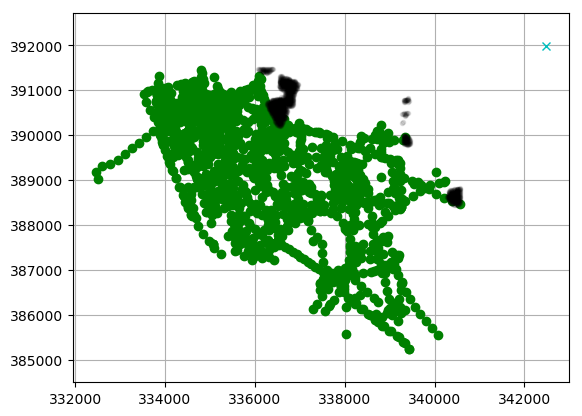

In [45]:
# plot the route??
# plt.plot(ox, oy, ".k")
# plt.plot(sx, sy, "og")
# plt.plot(gx, gy, "ob")
# plot route
for indx, indy in zip(rx, ry):
    plt.plot(rx, ry, "xc")

plt.grid(True)
plt.axis("equal")

# plot the demand and supply points
plt.plot(df_demand.demand_easting.tolist(), df_demand.demand_northing.tolist(), "og")
plt.plot(df_site.site_easting.tolist(), df_site.site_northing.tolist(), "og")

plt.plot(ox, oy, ".k", alpha = 0.1)

plt.show()

## Compute the pairwise A* distance

In [78]:
import a_star
from importlib import reload
reload(a_star) 
import a_star

In [79]:
# set show_animiation as False. Test the a_star main() function
a_star.show_animation = False
a_star.main()

/home/spacetimelab/hf_chen/drone_station_pmp/a_star.py start!!
min_x: -10
min_y: -10
max_x: 60
max_y: 60
x_width: 35
y_width: 35
len of route: 104.56854249492378
len of route in 3D: 104.56854249492378


In [80]:
# using the data from df_dtm
# height_no_fly = df_dtm.z.quantile(.9)

# using a subset of df_dtm: using the boundary of de_demand and df_site
tolerance = 20
max_x = np.maximum(df_demand.demand_easting.max(), df_site.site_easting.max()) + tolerance
max_y = np.maximum(df_demand.demand_northing.max(), df_site.site_northing.max()) + tolerance
min_x = np.minimum(df_demand.demand_easting.min(), df_site.site_easting.min()) - tolerance
min_y = np.minimum(df_demand.demand_northing.min(), df_site.site_northing.min()) - tolerance

df_dtm_subset = df_dtm.loc[(df_dtm.x >= min_x) & (df_dtm.x <= max_x) & (df_dtm.y >= min_y) & (df_dtm.y <= max_y)]

# if the whole df_dtm is used, uncommon the following command
# df_dtm_subset = df_dtm

# if a cell has a elevation higher than *threshold_quantile*, it is considered as the no-fly zone
threshold_quantile = 1
height_no_fly = df_dtm_subset.z.quantile(threshold_quantile)
size_x = df_dtm_subset.x.unique().size
size_y = df_dtm_subset.y.unique().size
step_len_x = (df_dtm_subset.x.max() - df_dtm_subset.x.min()) / (size_x - 1)
step_len_y = (df_dtm_subset.y.max() - df_dtm_subset.y.min()) / (size_y - 1)

# set the barriers or no-fly zone
df_dtm_over_height_no_fly = df_dtm_subset.loc[df_dtm_subset.z > height_no_fly]

# using step_len_x as grid_size (step_len_x = step_len_y = 20 m)
# assuming that robot_radius is the same as grid_size
ox = df_dtm_over_height_no_fly.x.tolist()
oy = df_dtm_over_height_no_fly.y.tolist()

a_star_planner = a_star.AStarPlanner(ox = ox, oy = oy, 
resolution = step_len_x, rr = None, 
min_x = df_dtm_subset.x.min(), max_x = df_dtm_subset.x.max(), min_y = df_dtm_subset.y.min(), max_y = df_dtm_subset.y.max(),
list_x = df_dtm_subset.x, list_y = df_dtm_subset.y, list_z = df_dtm_subset.z
)

min_x: 332450.0
min_y: 385230.0
max_x: 340570.0
max_y: 391470.0
resolution: 20.0
x_width: 407
y_width: 313


In [81]:
# describe the variation of df_dtm_subset
df_dtm_subset.z.describe()

count    127391.000000
mean         28.629826
std          20.314679
min          -7.348299
25%           7.313250
50%          29.698000
75%          47.219250
max          69.494510
Name: z, dtype: float64

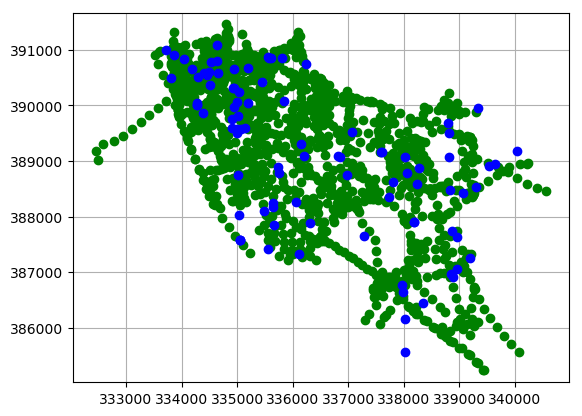

In [82]:
plt.grid(True)
plt.axis("equal")

# plot the demand and supply points
plt.plot(df_demand.demand_easting.tolist(), df_demand.demand_northing.tolist(), "og")
plt.plot(df_site.site_easting.tolist(), df_site.site_northing.tolist(), "ob")

plt.plot(ox, oy, ".k", alpha = 0.3)

plt.show()

In [ ]:
# plot the DTM

In [41]:
# are all demand points valid?
series_demand = df_demand.apply(lambda x: a_star_planner.verify_xy(x['demand_easting'], x['demand_northing']), axis=1)
print("number of invalid demand:", df_demand.shape[0] - series_demand.sum())
# are all supply points valid?
series_supply = df_site.apply(lambda x: a_star_planner.verify_xy(x['site_easting'], x['site_northing']), axis=1)
print("number of invalide supply:", df_site.shape[0] - series_supply.sum())

number of invalid demand: 0
number of invalide supply: 0


In [66]:
# any demand or supply point in the no-fly zone?
df_demand['in_nofly'] = df_demand.apply(lambda x: a_star_planner.is_in_obstacle_cell(x['demand_easting'], x['demand_northing']), axis=1)
print("Number of demand in no-fly zone", df_demand.in_nofly.sum())
df_site['in_nofly'] = df_site.apply(lambda x: a_star_planner.is_in_obstacle_cell(x['site_easting'], x['site_northing']), axis=1)
print("Number of site in no-fly zone", df_site.in_nofly.sum())

Number of demand in no-fly zone 0
Number of site in no-fly zone 0


In [67]:
# if a cell is in the no-fly zone and contains a demand or pontential site points, this cell should be removed from the no-fly zone
# reset
a_star_planner.reset(df_demand['demand_easting'].tolist(), df_demand['demand_northing'].tolist())
a_star_planner.reset(df_site['site_easting'].tolist(), df_site['site_northing'].tolist())

In [68]:
# confirm: all demand and supply points should be outside no-fly zone
df_demand['in_nofly'] = df_demand.apply(lambda x: a_star_planner.is_in_obstacle_cell(x['demand_easting'], x['demand_northing']), axis=1)
print("Number of demand in no-fly zone", df_demand.in_nofly.sum())
assert(df_demand.in_nofly.sum() == 0)
df_site['in_nofly'] = df_site.apply(lambda x: a_star_planner.is_in_obstacle_cell(x['site_easting'], x['site_northing']), axis=1)
print("Number of site in no-fly zone", df_site.in_nofly.sum())
assert(df_site.in_nofly.sum() == 0)

Number of demand in no-fly zone 0
Number of site in no-fly zone 0


In [ ]:
# !pip3 install swifter

In [ ]:
%%script false --no-raise-error
from tqdm import tqdm
# tqdm.pandas()
import swifter
df_distance_ss = df_distance.iloc[1:1000,]
df_distance_ss['constrained'] = df_distance_ss.swifter.apply(lambda x: a_star_planner.planning(x['demand_easting'], x['demand_northing'],x['site_easting'], x['site_northing']), axis=1)

In [59]:
from tqdm import tqdm
tqdm.pandas()
# df_distance_ss_2 = df_distance.iloc[1:1000,]
df_distance['constrained'] = df_distance.progress_apply(lambda x: a_star_planner.planning(x['demand_easting'], x['demand_northing'],x['site_easting'], x['site_northing']), axis=1)

100%|██████████| 999/999 [07:16<00:00,  2.29it/s]
/home/spacetimelab/anaconda3/envs/travel_mode_pred/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [1]:
%%script false --no-raise-error
# test dask. Not work well
import dask.dataframe as dd
df_distance_ss_2 = df_distance.iloc[1:1000,]
ddf = dd.from_pandas(df_distance_ss_2, npartitions=13) # find your own number of partitions
ddf_update = ddf.apply(lambda x: a_star_planner.planning(x['demand_easting'], x['demand_northing'],x['site_easting'], x['site_northing']), axis=1).compute()
# ddf_update = ddf.apply(your_func, axis=1).compute()

In [ ]:
# !pip3 install mapply

In [ ]:
# test mapplly
import mapply
# use all cores
mapply.init(n_workers=-1)
# df_distance_ss_2 = df_distance.iloc[1:1000,]
df_distance['constrained'] = df_distance.mapply(lambda x: a_star_planner.planning(x['demand_easting'], x['demand_northing'],x['site_easting'], x['site_northing']), axis=1)

In [84]:
# test mapplly
import mapply
# use all cores
mapply.init(n_workers=-1)
df_distance_ss_2 = df_distance.iloc[1:1000,]
df_distance_ss_2['constrained'] = df_distance_ss_2.mapply(lambda x: a_star_planner.planning(x['demand_easting'], x['demand_northing'],x['site_easting'], x['site_northing']), axis=1)

print(len(df_distance_ss_2['constrained'].iloc[0]))
print(len(df_distance_ss_2['constrained'].iloc[0][0]))
print(len(df_distance_ss_2['constrained'].iloc[0][1]))
print(df_distance_ss_2['constrained'].iloc[0][2])
print(df_distance_ss_2['constrained'].iloc[0][3])

  0%|          | 0/9 [00:00<?, ?it/s]

4
174
174
3749.9494936611645
3753.193444575922


/home/spacetimelab/anaconda3/envs/travel_mode_pred/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [93]:
df_distance_ss_2.columns

Index(['site_id', 'site_long', 'site_lat', 'site_easting', 'site_northing',
       'demand_id', 'demand_long', 'demand_lat', 'demand_easting',
       'demand_northing', 'constrained'],
      dtype='object')

In [94]:
# test mapplly
import mapply
# use all cores
mapply.init(n_workers=-1)
# df_distance_ss_2 = df_distance.iloc[1:1000,]
series_distance_constrained = df_distance.mapply(lambda x: a_star_planner.planning(x['demand_easting'], x['demand_northing'],x['site_easting'], x['site_northing']), axis=1)

  0%|          | 0/168 [00:00<?, ?it/s]

TypeError: 'int' object is not subscriptable

In [113]:
# There are 168 columns in the series_distance_constrained, corresponding to 168 chunks
print("Columns in this dataframe: ", series_distance_constrained.shape[1])
# each column has a 1/168 proportion of non-na values
print("Number of NAN values in each column")
print(series_distance_constrained.isna().sum())

Columns in this dataframe:  168
Number of NAN values in each column
0      158083
1      158083
2      158083
3      158083
4      158083
        ...  
163    158084
164    158084
165    158084
166    158084
167    158084
Length: 168, dtype: int64


In [115]:
# to get the non-na value in each row
series_df_3D_distance = series_distance_constrained.fillna(method='bfill', axis=1).iloc[:, 0]

# compute the ratio of 2D and 3D distance
ratio_2D_3D_distance = pd.Series([x[3]/x[2] for x in series_df_3D_distance])
ratio_2D_3D_distance.describe()

/home/spacetimelab/anaconda3/envs/travel_mode_pred/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


count    159027.000000
mean          1.001028
std           0.001159
min           1.000000
25%           1.000456
50%           1.000716
75%           1.001205
max           1.116436
dtype: float64

In [116]:
# assign the values of 3D distance to df_distance
list_3D_distance = [x[3] for x in series_df_3D_distance]

In [ ]:
series_distance_constrained.to_csv('df_distance_3D.csv')

In [92]:
df_distance.columns

Index(['site_id', 'site_long', 'site_lat', 'site_easting', 'site_northing',
       'demand_id', 'demand_long', 'demand_lat', 'demand_easting',
       'demand_northing'],
      dtype='object')

In [86]:

# not much difference

count    999.000000
mean       1.000740
std        0.000617
min        1.000089
25%        1.000327
50%        1.000594
75%        1.000874
max        1.004734
dtype: float64

In [ ]:
df_distance.to_csv('df_distance.csv')

In [ ]:
df_distance['constrained_3D'] = df_distance.apply(lambda x: x['constrained'].iloc[0][3])
df_distance[['constrained_3D']].to_csv('df_distance_3D.csv')
df_distance.to_csv('df_distance.csv')

In [ ]:
df_distance['constrained'] = df_distance.progress_apply(lambda x: a_star_planner.planning(x['demand_easting'], x['demand_northing'],x['site_easting'], x['site_northing']), axis=1)

## Download the DTM data (Not run the code in this part)

In [144]:
# check the new tiff and resample
from osgeo import gdal
raster_DTM = gdal.Open("DTM/DTM_merge.tif")
# number of raster bands
print(raster_DTM.RasterCount)
print("Width: {}, Height: {}".format(raster_DTM.RasterXSize,raster_DTM.RasterYSize))
print("crs: {}".format(raster_DTM.GetProjection()))

1
Width: 7500, Height: 7500
crs: PROJCS["OSGB 1936 / British National Grid",GEOGCS["OSGB 1936",DATUM["OSGB_1936",SPHEROID["Airy 1830",6377563.396,299.3249646000044,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4277"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.9996012717],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","27700"]]


In [112]:
# plot 
fig, ax = plt.subplots(figsize=(6, 6))
gdf_liverpool_hub_four.plot(ax=ax, color='white', edgecolor='black')
gdf_dtm_1.plot(ax=ax)
plt.show()

KeyboardInterrupt: 

In [101]:
# create a dataframe of the bounding box of gdf_liverpool_hub_four
# gdf_bbox = gpd.GeoDataFrame(gdf_liverpool_hub_four.total_bounds)
# gdf_bbox.to_file("bbox_Liverpool_hub_four.shp")

bbox = gdf_liverpool_hub_four.envelope
gdf_bbox = gpd.GeoDataFrame(gpd.GeoSeries(bbox), columns=['geometry'])
gdf_bbox.to_file("bbox_Liverpool_hub_four.shp")

In [92]:
# clip it using the bounding box of the case study area
from shapely.geometry import box

bbox = box(*gdf_liverpool_hub_four.total_bounds)
# print(gdf_liverpool_hub_four.total_bounds)
# print(gdf_dtm.total_bounds)

# gdf_dtm_clipped = gpd.clip(gdf_dtm, mask=bbox)


(16, 4)


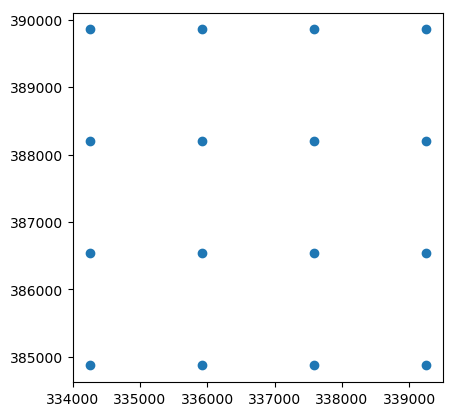

In [96]:
# plot this subset
# gdf_dtm_clipped.plot("z", cmap="Blues")
print(gdf_dtm_clipped.shape)
gdf_dtm_clipped.plot()
plt.show()
# if a pixel is outside the case study area, it is assign with a infinity value


## 3D Euclidean distance

In [117]:
df_distance['3D'] = list_3D_distance

In [118]:
# The distance matrix required by spopt is a M*N matrix, with M rows and N columns corresponding to demands and sites
df_distance_pivot_constrained = pd.pivot_table(df_distance, values='3D', index=['demand_id'],
                    columns=['site_id'], aggfunc=np.sum)

In [119]:
print(df_distance_pivot_constrained.index)
print(df_distance_pivot_constrained.columns)

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709],
           dtype='int64', name='demand_id', length=1710)
Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
            85, 86, 87, 88, 89, 90, 91, 92],
           dtype='int64', name='site_id')


In [120]:
# save as Euclidean_distance_site_demand.csv
file_distance_cons = 'distance_matrix_demand_site_3D.csv'
df_distance_pivot_constrained.to_csv(file_distance_cons)

In [121]:
array_distance_Eudlidean = utilities.read_distance_matrix_as_np_array(file_distance_cons)
assert(array_distance_Eudlidean.shape == (1710, 93))

## Save distance dataframe